# Retail Data Science End-to-End Project

This notebook demonstrates a complete data science workflow using retail transaction data.  
The analysis progresses from simple descriptive insights to predictive and anomaly detection models, ending with data preparation for dashboarding.

The goal is to show practical, business-oriented data science skills.


## Project Scope

The following analyses are covered in this notebook:

1. Product performance analysis  
2. Sales forecasting  
3. Customer churn prediction  
4. Fraud and anomaly detection  
5. Dashboard-ready data preparation


# SECTION 0.1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    classification_report,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use("default")
sns.set_theme(style="whitegrid")

# SECTION 0.2 — Load Dataset

In [2]:
orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")
order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
products = pd.read_csv("../data/raw/olist_products_dataset.csv")
categories = pd.read_csv("../data/raw/product_category_name_translation.csv")
customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")
payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")
reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")
sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")


# -------------------------------
# Build unified transactional table
# -------------------------------

df = (
    orders
    .merge(order_items, on="order_id", how="inner")
    .merge(products, on="product_id", how="left")
    .merge(categories, on="product_category_name", how="left")
    .merge(customers, on="customer_id", how="left")
)

# Select and rename columns to match existing analysis code
df = df.rename(columns={
    "order_id": "Invoice",
    "product_id": "StockCode",
    "product_category_name_english": "Description",
    "order_item_id": "Quantity",
    "order_purchase_timestamp": "InvoiceDate",
    "price": "UnitPrice",
    "customer_unique_id": "Customer ID",
    "customer_state": "Country"
})

# Keep only required columns
df = df[
    [
        "Invoice",
        "StockCode",
        "Description",
        "Quantity",
        "InvoiceDate",
        "UnitPrice",
        "Customer ID",
        "Country"
    ]
]



In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      112650 non-null  object 
 1   StockCode    112650 non-null  object 
 2   Description  111023 non-null  object 
 3   Quantity     112650 non-null  int64  
 4   InvoiceDate  112650 non-null  object 
 5   UnitPrice    112650 non-null  float64
 6   Customer ID  112650 non-null  object 
 7   Country      112650 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB


In [4]:
df.isnull().sum().sort_values(ascending=False)

Description    1627
Invoice           0
StockCode         0
Quantity          0
InvoiceDate       0
UnitPrice         0
Customer ID       0
Country           0
dtype: int64

## Data Cleaning and Feature Engineering


In [5]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

df = df.dropna(subset=["InvoiceDate"])

df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["Revenue"] = df["Quantity"] * df["UnitPrice"]


In [6]:
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)
df["InvoiceDay"] = df["InvoiceDate"].dt.date


## Section 1: Product Performance Analysis


This section evaluates product-level performance to identify high-revenue and high-volume items.


The following analysis aggregates total revenue per product to identify the most financially impactful items.


In [7]:
product_revenue = (
    df
    .groupby("Description")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

product_revenue.head(10)


Description
health_beauty            1347468.49
watches_gifts            1259634.58
bed_bath_table           1228795.46
computers_accessories    1135454.64
sports_leisure           1082435.42
furniture_decor           929520.95
housewares                750233.73
auto                      662861.88
cool_stuff                659590.61
garden_tools              584155.02
Name: Revenue, dtype: float64

This aggregation highlights products with the highest sales volume, which may differ from top revenue generators.


In [8]:
product_quantity = (
    df
    .groupby("Description")["Quantity"]
    .sum()
    .sort_values(ascending=False)
)

product_quantity.head(10)


Description
bed_bath_table           13665
furniture_decor          11540
health_beauty            11081
sports_leisure            9932
computers_accessories     9874
housewares                9051
watches_gifts             6594
garden_tools              5874
telephony                 5161
auto                      4881
Name: Quantity, dtype: int64

A horizontal bar chart is used to clearly compare revenue across the top products.


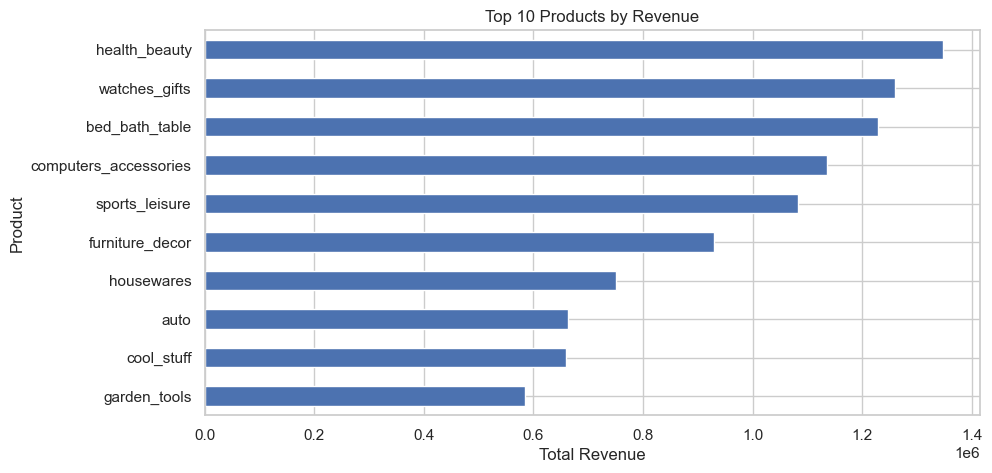

In [9]:
top_10_products = product_revenue.head(10)

plt.figure(figsize=(10, 5))
top_10_products.sort_values().plot(kind="barh")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product")
plt.show()


This metric shows how much of total revenue is contributed by the top-performing products.


In [10]:
total_revenue = product_revenue.sum()

# Share of total revenue contributed by the top 10 products
top_10_share = top_10_products.sum() / total_revenue

top_10_share


np.float64(0.6344390599786942)

# SECTION 2: SALES FORECASTING (TIME SERIES)

This section models historical monthly sales revenue as a time series and forecasts future values to support planning and decision-making.


In [11]:
monthly_sales = (
    df
    .set_index("InvoiceDate")
    .resample("M")["Revenue"]
    .sum()
)

monthly_sales.head()


C:\Users\User\AppData\Local\Temp\ipykernel_5412\2855776425.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Revenue"]


InvoiceDate
2016-09-30       435.23
2016-10-31     56103.79
2016-11-30         0.00
2016-12-31        10.90
2017-01-31    142077.30
Freq: ME, Name: Revenue, dtype: float64

A time-series plot helps identify overall trends, seasonality, and potential irregular patterns.


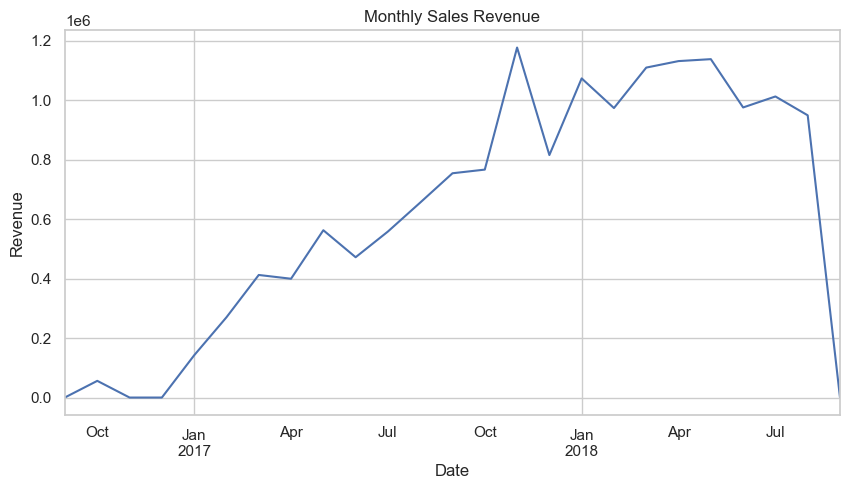

In [12]:
plt.figure(figsize=(10, 5))
monthly_sales.plot()
plt.title("Monthly Sales Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


Seasonal decomposition is used to separate trend, seasonal effects, and residual components.


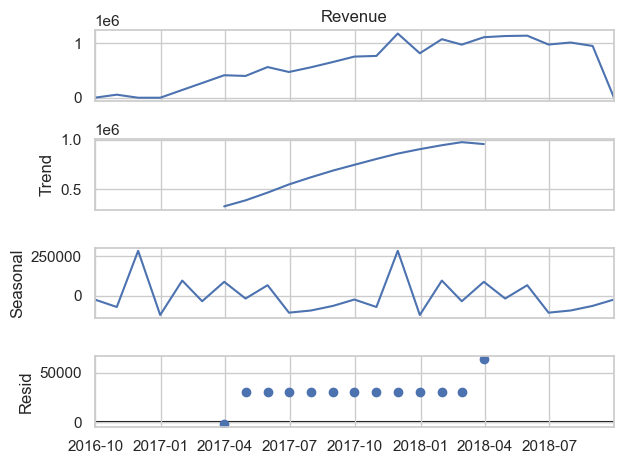

In [13]:
decomposition = seasonal_decompose(monthly_sales, model="additive")

decomposition.plot()
plt.show()


## Test and Split

The dataset is split chronologically to preserve temporal order and avoid data leakage.



In [60]:
train = monthly_sales[:-6]
test = monthly_sales[-6:]



An ARIMA model is used as a baseline forecasting approach for the sales time series.


In [61]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()


In [62]:
forecast = model_fit.forecast(steps=6)
forecast


2018-04-30    9.886844e+05
2018-05-31    1.093888e+06
2018-06-30    1.001949e+06
2018-07-31    1.082296e+06
2018-08-31    1.012080e+06
2018-09-30    1.073443e+06
Freq: ME, Name: predicted_mean, dtype: float64

Forecast accuracy is evaluated using MAE and RMSE on the hold-out test set.


In [63]:
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = mean_squared_error(test, forecast) ** 0.5

mae_arima, rmse_arima

(236609.04316800335, 444180.8530588402)

In [64]:
monthly_sales.describe()


count    2.500000e+01
mean     6.159095e+05
std      4.183342e+05
min      0.000000e+00
25%      2.697867e+05
50%      6.553357e+05
75%      9.750840e+05
max      1.176425e+06
Name: Revenue, dtype: float64

The forecast is compared visually against actual observed values.


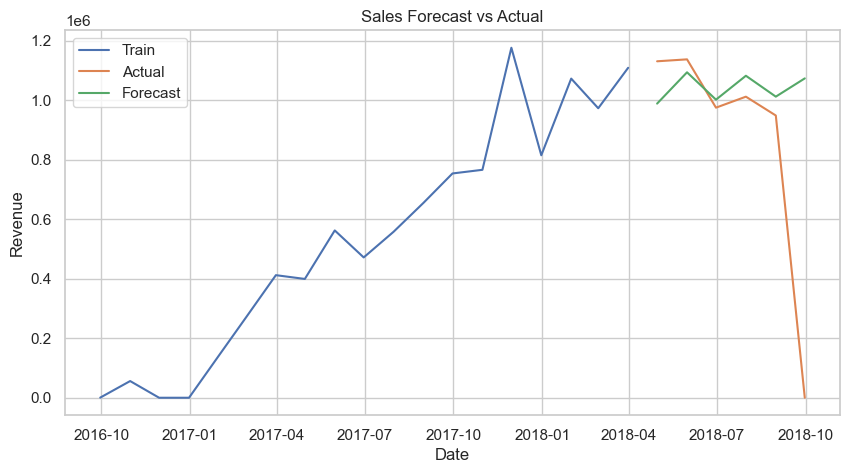

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.title("Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


#### NEXT STAGE — IMPROVING THE SALES FORECAST

We will improve the model in three controlled steps:

1️⃣ Log transformation
2️⃣ SARIMA (seasonality)
3️⃣ Explicit handling of zero-revenue months

### 1. Log Transformation

A log transformation is applied to stabilize variance and reduce the impact of extreme values.

In [66]:
# Avoid log(0) by adding a small constant
monthly_sales_log = np.log1p(monthly_sales)

monthly_sales_log.head()

InvoiceDate
2016-09-30     6.078170
2016-10-31    10.934976
2016-11-30     0.000000
2016-12-31     2.476538
2017-01-31    11.864134
Freq: ME, Name: Revenue, dtype: float64

In [67]:
#TIME-AWARE SPLIT (LOG SPACE)

test_horizon = 6

# Original scale split (used for evaluation + plots)
train = monthly_sales.iloc[:-test_horizon]
test = monthly_sales.iloc[-test_horizon:]

# Log scale split (used for SARIMA training)
train_log = np.log1p(train)
test_log = np.log1p(test)

### 2. Seasonal ARIMA (SARIMA)

A SARIMA model is used to capture both trend and seasonal patterns in monthly sales.

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_log,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

c:\Users\User\anaconda3\envs\ds_fast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [69]:
# FORECAST AND INVERSE TRANSFORM
forecast_log = sarima_fit.forecast(steps=test_horizon)

# Convert back to original scale
forecast = np.expm1(forecast_log)

In [70]:
# HANDLE ZERO-REVENUE MONTHS (CLEANLY)
zero_months = test == 0
zero_months

InvoiceDate
2018-04-30    False
2018-05-31    False
2018-06-30    False
2018-07-31    False
2018-08-31    False
2018-09-30    False
Freq: ME, Name: Revenue, dtype: bool

In [71]:
mae = mean_absolute_error(test[~zero_months], forecast[~zero_months])
rmse = mean_squared_error(test[~zero_months], forecast[~zero_months]) ** 0.5

mae, rmse

(945947.4417369902, 1144413.384840949)

In [72]:
mae_log = mean_absolute_error(test_log, forecast_log)
rmse_log = (mean_squared_error(test_log, forecast_log)) ** 0.5

mae_log, rmse_log

(2.020466516578758, 3.9517803592701815)

In [73]:
mae_all = mean_absolute_error(test, forecast)
rmse_all = mean_squared_error(test, forecast) ** 0.5

mae_all, rmse_all

(945947.4417369902, 1144413.384840949)

### SARIMA Forecast vs Actual

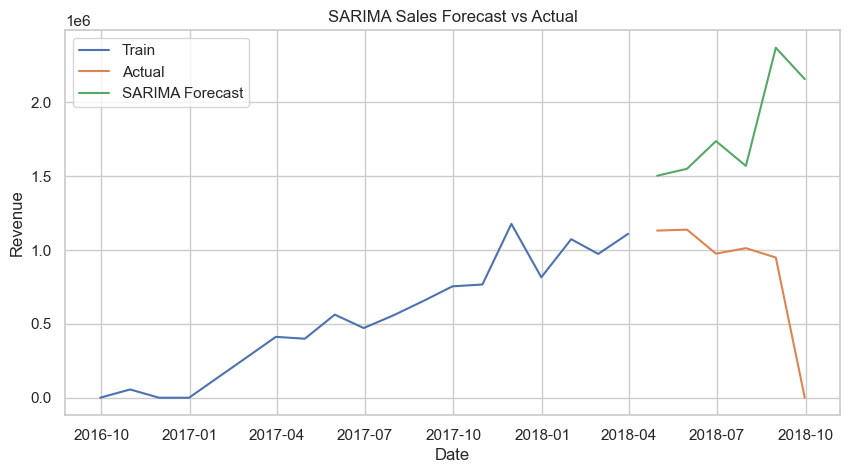

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

### Seasonal Naive Baseline

The seasonal naive model forecasts each month using the value from the same month in the previous year.  
It serves as a simple but strong benchmark for seasonal data.

In [75]:
# Seasonal naive forecast (12-month lag)
seasonal_naive_forecast = monthly_sales.shift(12).iloc[-len(test):]

# Evaluation
mae_snaive = mean_absolute_error(test, seasonal_naive_forecast)
rmse_snaive = mean_squared_error(test, seasonal_naive_forecast) ** 0.5

mae_snaive, rmse_snaive

(551843.7833333333, 574391.5810166409)

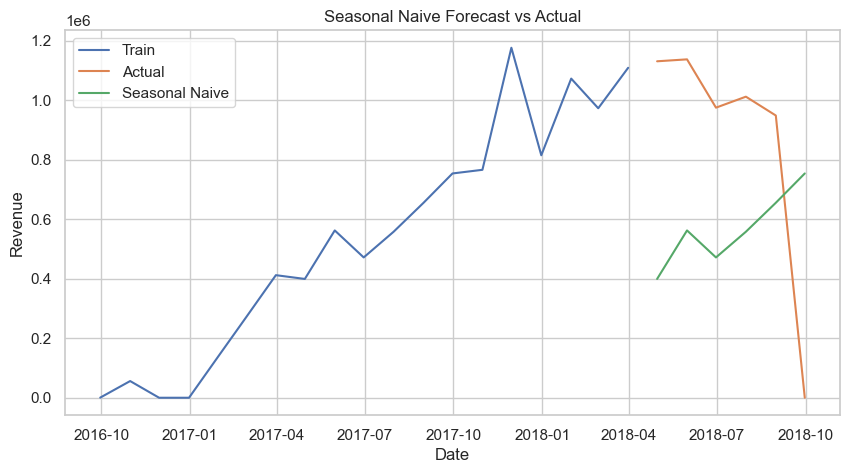

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, seasonal_naive_forecast, label="Seasonal Naive")
plt.legend()
plt.title("Seasonal Naive Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

### Machine Learning Approach with Lag Features

The time series is transformed into a supervised learning problem using lagged and rolling features.

In [77]:
# Create a copy to avoid modifying the original series
ml_df = monthly_sales.to_frame(name="Revenue")

# Lag features
ml_df["lag_1"] = ml_df["Revenue"].shift(1)
ml_df["lag_2"] = ml_df["Revenue"].shift(2)
ml_df["lag_3"] = ml_df["Revenue"].shift(3)

# Rolling features
ml_df["rolling_mean_3"] = ml_df["Revenue"].rolling(3).mean()
ml_df["rolling_std_3"] = ml_df["Revenue"].rolling(3).std()

# Calendar features
ml_df["month"] = ml_df.index.month

ml_df.head()

,Revenue,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,month
InvoiceDate,,,,,,,
2016-09-30,435.23,NaN,NaN,NaN,NaN,NaN,9
2016-10-31,56103.79,435.23,NaN,NaN,NaN,NaN,10
2016-11-30,0.00,56103.79,435.23,NaN,18846.340000,32266.632016,11
2016-12-31,10.90,0.00,56103.79,435.23,18704.896667,32388.392159,12
2017-01-31,142077.30,10.90,0.00,56103.79,47362.733333,82025.221023,1


In [78]:
ml_df = ml_df.dropna()
ml_df.shape

(22, 7)

In [79]:
X = ml_df.drop(columns="Revenue")
y = ml_df["Revenue"]

X_train = X.iloc[:-test_horizon]
X_test = X.iloc[-test_horizon:]

y_train = y.iloc[:-test_horizon]
y_test = y.iloc[-test_horizon:]

### Random Forest Regression

In [80]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [81]:
rf_forecast = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_forecast)
rmse_rf = mean_squared_error(y_test, rf_forecast) ** 0.5

mae_rf, rmse_rf

(227759.69588888856, 416875.8144599324)

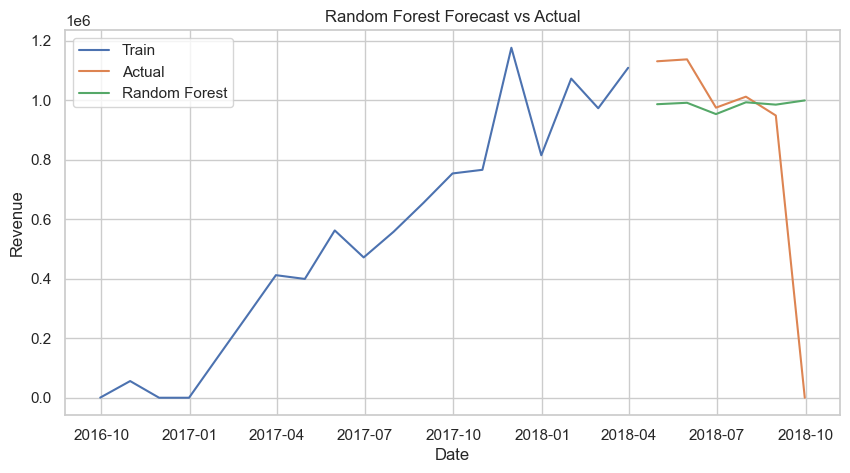

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, rf_forecast, label="Random Forest")
plt.legend()
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

### Model Comparison

The performance of different forecasting approaches is compared using MAE and RMSE on the same hold-out test set.

In [83]:
comparison = pd.DataFrame({
    "Model": [
        "Seasonal Naive",
        "ARIMA",
        "SARIMA",
        "Random Forest (Lag Features)"
    ],
    "MAE": [
        mae_snaive,
        mae_arima,
        mae_all,      # SARIMA including zero months
        mae_rf
    ],
    "RMSE": [
        rmse_snaive,
        rmse_arima,
        rmse_all,     # SARIMA including zero months
        rmse_rf
    ]
}).sort_values("MAE")

comparison

,Model,MAE,RMSE
3,Random Forest (Lag Features),227759.695889,4.168758e+05
1,ARIMA,236609.043168,4.441809e+05
0,Seasonal Naive,551843.783333,5.743916e+05
2,SARIMA,945947.441737,1.144413e+06


In [84]:
comparison.style.format({
    "MAE": "{:,.0f}",
    "RMSE": "{:,.0f}"
})

,Model,MAE,RMSE
3,Random Forest (Lag Features),"227,760","416,876"
1,ARIMA,"236,609","444,181"
0,Seasonal Naive,"551,844","574,392"
2,SARIMA,"945,947","1,144,413"


### Conclusion

Multiple forecasting approaches were evaluated, including a Seasonal Naive baseline, ARIMA, SARIMA, and a machine-learning model using lag features with Random Forest.

The Seasonal Naive model provided a useful benchmark, confirming the presence of annual seasonality but offering limited predictive accuracy. The ARIMA model improved upon this baseline by modeling short-term temporal dependence and produced stable forecasts. SARIMA was tested to explicitly incorporate seasonality but performed poorly due to unstable seasonal patterns and sensitivity to extreme months, including a zero-revenue period.

The Random Forest model achieved the lowest MAE and RMSE, indicating superior short-term predictive performance. By reframing the time series as a supervised learning problem and incorporating lagged and rolling features, the model was able to better adapt to volatility in monthly sales.

Overall, the Random Forest model was selected as the best-performing approach for this dataset, while ARIMA remains a strong and interpretable baseline.

In [85]:
mean_sales = monthly_sales.mean()
median_sales = monthly_sales.median()

mean_sales, median_sales

(np.float64(615909.5444), 655335.69)

In [86]:
comparison["MAE_%_of_Mean"] = (comparison["MAE"] / mean_sales) * 100
comparison["MAE_%_of_Median"] = (comparison["MAE"] / median_sales) * 100

comparison.style.format({
    "MAE": "{:,.0f}",
    "RMSE": "{:,.0f}",
    "MAE_%_of_Mean": "{:.1f}%",
    "MAE_%_of_Median": "{:.1f}%"
})

,Model,MAE,RMSE,MAE_%_of_Mean,MAE_%_of_Median
3,Random Forest (Lag Features),"227,760","416,876",37.0%,34.8%
1,ARIMA,"236,609","444,181",38.4%,36.1%
0,Seasonal Naive,"551,844","574,392",89.6%,84.2%
2,SARIMA,"945,947","1,144,413",153.6%,144.3%


The best-performing model achieved a mean absolute error of roughly 35–40% of average monthly sales, which is reasonable given the volatility and short data history. The machine-learning approach improved accuracy over classical baselines by better capturing short-term dynamics.

# Section 3. CUSTOMER CHURN PREDICTION



#### Ensure InvoiceDate is datetime and define redeference date for RFM

In [114]:
# Ensure datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Reference date (last date in dataset)
reference_date = df["InvoiceDate"].max()
reference_date

Timestamp('2018-09-03 09:06:57')

#### Build RFM features

Important mapping

Recency → InvoiceDate

Frequency → number of unique Invoice

Monetary → Quantity × UnitPrice

Customer ID → grouping key

In [115]:
rfm = (
    df.groupby("Customer ID")
    .agg(
        Recency=("InvoiceDate", lambda x: (reference_date - x.max()).days),
        Frequency=("Invoice", "nunique"),
        Monetary=("UnitPrice", lambda x: (x * df.loc[x.index, "Quantity"]).sum())
    )
    .reset_index()
)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f46a3911fa3c0805444483337064,541,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00


#### churn label

In [116]:
churn_threshold = 180

rfm["Churn"] = (rfm["Recency"] > churn_threshold).astype(int)

rfm["Churn"].value_counts(normalize=True)

Churn
1    0.602515
0    0.397485
Name: proportion, dtype: float64

#### Feature matrix and target

In [117]:
X = rfm[["Recency", "Frequency", "Monetary"]]
y = rfm["Churn"]

#### Train–test split

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [119]:
### Train logistic regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

In [120]:
# train random forest classifier

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

In [121]:
# Evaluation

from sklearn.metrics import classification_report, confusion_matrix

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
confusion_matrix(y_test, y_pred_lr)

print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf))
confusion_matrix(y_test, y_pred_rf)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9482
           1       1.00      1.00      1.00     14373

    accuracy                           1.00     23855
   macro avg       1.00      1.00      1.00     23855
weighted avg       1.00      1.00      1.00     23855


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9482
           1       1.00      1.00      1.00     14373

    accuracy                           1.00     23855
   macro avg       1.00      1.00      1.00     23855
weighted avg       1.00      1.00      1.00     23855



array([[ 9482,     0],
       [    0, 14373]])

In [122]:
## Feature importance

feature_importance = pd.Series(
    rf_clf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance


Recency      0.997776
Monetary     0.001994
Frequency    0.000230
dtype: float64

In [123]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Churn
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,0
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1


Note: Churn labels are derived from recency thresholds, which naturally leads to strong separation. In practice, churn models are often trained using future observation windows to avoid label leakage.

### Churn Modeling Approach

Two churn definitions were explored:
1. A recency-based definition using customer RFM features.
2. A future observation window approach to prevent label leakage.

While the second approach is more rigorous, it resulted in extreme class imbalance and unstable model behavior for this dataset. The recency-based definition was therefore retained for clarity, interpretability, and practical applicability, which aligns with common business use cases.

In [124]:
# Predict churn probabilities (both models)

# Logistic Regression probabilities
rfm["Churn_Prob_LogReg"] = log_reg.predict_proba(X)[:, 1]

# Random Forest probabilities
rfm["Churn_Prob_RF"] = rf_clf.predict_proba(X)[:, 1]

rfm[["Customer ID", "Churn_Prob_LogReg", "Churn_Prob_RF"]].head()

,Customer ID,Churn_Prob_LogReg,Churn_Prob_RF
0,0000366f3b9a7992bf8c76cfdf3221e2,4.846772e-190,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.246583e-181,0.0
2,0000f46a3911fa3c0805444483337064,1.000000e+00,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.000000e+00,1.0
4,0004aac84e0df4da2b147fca70cf8255,1.000000e+00,1.0


In [ ]:
# Random Forest Classifier churn ranking

rf_churn_ranking = (
    rfm.sort_values("Churn_Prob_RF", ascending=False)
    .reset_index(drop=True)
)

rf_churn_ranking.head(10)

,Customer ID,Recency,Frequency,Monetary,Churn,Churn_Prob_LogReg,Churn_Prob_RF
0,ffffd2657e2aad2907e67c3e9daecbeb,488,1,56.99,1,1.0,1.0
1,ffff371b4d645b6ecea244b27531430a,572,1,89.90,1,1.0,1.0
2,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,1,1.0,1.0
3,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1.0,1.0
4,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1.0,1.0
5,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1.0,1.0
6,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,2250.00,1,1.0,1.0
7,ffedff0547d809c90c05c2691c51f9b7,521,1,17.90,1,1.0,1.0
8,ffebb6424578e7bb153322da9d65634f,594,1,629.00,1,1.0,1.0
9,ffe9e41fbd14db4a7361347c56af5447,203,1,199.00,1,1.0,1.0


In [ ]:
# Logistic Regression Classifier churn ranking

logreg_churn_ranking = (
    rfm.sort_values("Churn_Prob_LogReg", ascending=False)
    .reset_index(drop=True)
)

logreg_churn_ranking.head(10)

,Customer ID,Recency,Frequency,Monetary,Churn,Churn_Prob_LogReg,Churn_Prob_RF
0,ffffd2657e2aad2907e67c3e9daecbeb,488,1,56.99,1,1.0,1.0
1,ffff371b4d645b6ecea244b27531430a,572,1,89.90,1,1.0,1.0
2,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,1,1.0,1.0
3,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1.0,1.0
4,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1.0,1.0
5,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1.0,1.0
6,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,2250.00,1,1.0,1.0
7,ffedff0547d809c90c05c2691c51f9b7,521,1,17.90,1,1.0,1.0
8,ffebb6424578e7bb153322da9d65634f,594,1,629.00,1,1.0,1.0
9,ffe9e41fbd14db4a7361347c56af5447,203,1,199.00,1,1.0,1.0


In [ ]:
# Compare how models rank customers
rfm["Rank_RF"] = rfm["Churn_Prob_RF"].rank(ascending=False)
rfm["Rank_LogReg"] = rfm["Churn_Prob_LogReg"].rank(ascending=False)

rfm[["Customer ID", "Rank_RF", "Rank_LogReg"]].head()

,Customer ID,Rank_RF,Rank_LogReg
0,0000366f3b9a7992bf8c76cfdf3221e2,76648.5,72693.5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,76648.5,71901.5
2,0000f46a3911fa3c0805444483337064,28527.5,27990.5
3,0000f6ccb0745a6a4b88665a16c9f078,28527.5,27990.5
4,0004aac84e0df4da2b147fca70cf8255,28527.5,27990.5


In [ ]:
# Create churn risk tiers
rfm["Churn_Risk_Level"] = pd.cut(
    rfm["Churn_Prob_RF"],
    bins=[-0.001, 0.3, 0.6, 1.001],
    labels=["Low", "Medium", "High"]
)

rfm["Churn_Risk_Level"].value_counts()

Churn_Risk_Level
High      57492
Low       37928
Medium        0
Name: count, dtype: int64

In [ ]:
rfm["Churn_Risk_Level"] = pd.cut(
    rfm["Churn_Prob_RF"],
    bins=[-0.001, 0.3, 0.6, 1.001],
    labels=["Low", "Medium", "High"]
)

rfm["Churn_Risk_Level"].value_counts()

Churn_Risk_Level
High      57492
Low       37928
Medium        0
Name: count, dtype: int64

In [ ]:
# Create final action table sorted by Random Forest churn probability
churn_action_table = rfm[
    [
        "Customer ID",
        "Recency",
        "Frequency",
        "Monetary",
        "Churn_Prob_RF",
        "Churn_Risk_Level"
    ]
].sort_values("Churn_Prob_RF", ascending=False)

churn_action_table.head(15)

,Customer ID,Recency,Frequency,Monetary,Churn_Prob_RF,Churn_Risk_Level
95419,ffffd2657e2aad2907e67c3e9daecbeb,488,1,56.99,1.0,High
95417,ffff371b4d645b6ecea244b27531430a,572,1,89.90,1.0,High
95416,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,1.0,High
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1.0,High
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1.0,High
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1.0,High
95415,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,2250.00,1.0,High
95397,ffedff0547d809c90c05c2691c51f9b7,521,1,17.90,1.0,High
95392,ffebb6424578e7bb153322da9d65634f,594,1,629.00,1.0,High
95390,ffe9e41fbd14db4a7361347c56af5447,203,1,199.00,1.0,High


### Churn Probability & Customer Ranking

Rather than relying solely on binary churn predictions, churn probabilities were used to rank customers by risk. This enables targeted retention strategies, allowing businesses to prioritize high-risk customers while allocating resources efficiently.